In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
year = 2022

In [3]:
results      = pd.read_csv("archive/results.csv")
races        = pd.read_csv("archive/races.csv")
drivers      = pd.read_csv("archive/drivers.csv")
constructors = pd.read_csv("archive/constructors.csv")
circuits     = pd.read_csv("archive/circuits.csv")
status       = pd.read_csv("archive/status.csv")

In [4]:
races_q = races[["raceId", "year", "round", "circuitId", "name"]].rename(
    columns={"name": "race_name"}
)

In [5]:
drivers_q = drivers[["driverId", "code", "surname"]].copy()
drivers_q["driver_name"] = drivers_q["surname"].fillna(drivers_q["code"]).fillna("Unknown")
constructors_q = constructors[["constructorId", "name"]].rename(columns={"name": "team_name"})
circuits_q= circuits[["circuitId", "name"]].rename(columns={"name": "circuit_name"})


In [6]:
df = (results.merge(races_q, on="raceId", how="left")
             .merge(drivers_q[["driverId", "driver_name"]], on="driverId", how="left")
             .merge(constructors_q, on="constructorId", how="left")
             .merge(circuits_q, on="circuitId", how="left") 
             .merge(status, on="statusId", how="left")
    )

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapSpeed,statusId,year,round,circuitId,race_name,driver_name,team_name,circuit_name,status
0,1,18,1,1,22,1,1,1,1,10.0,...,218.300,1,2008,1,1,Australian Grand Prix,Hamilton,McLaren,Albert Park Grand Prix Circuit,Finished
1,2,18,2,2,3,5,2,2,2,8.0,...,217.586,1,2008,1,1,Australian Grand Prix,Heidfeld,BMW Sauber,Albert Park Grand Prix Circuit,Finished
2,3,18,3,3,7,7,3,3,3,6.0,...,216.719,1,2008,1,1,Australian Grand Prix,Rosberg,Williams,Albert Park Grand Prix Circuit,Finished
3,4,18,4,4,5,11,4,4,4,5.0,...,215.464,1,2008,1,1,Australian Grand Prix,Alonso,Renault,Albert Park Grand Prix Circuit,Finished
4,5,18,5,1,23,3,5,5,5,4.0,...,218.385,1,2008,1,1,Australian Grand Prix,Kovalainen,McLaren,Albert Park Grand Prix Circuit,Finished


In [9]:
print(year)
if year is not None:
    print("here")
    df = df[df["year"] == year].copy()
print(df.head())

2022
here
       resultId  raceId  driverId  constructorId number  grid position  \
25400     25406    1074       844              6     16     1        1   
25401     25407    1074       832              6     55     3        2   
25402     25408    1074         1            131     44     5        3   
25403     25409    1074       847            131     63     9        4   
25404     25410    1074       825            210     20     7        5   

      positionText  positionOrder  points  ...  fastestLapSpeed statusId  \
25400            1              1    26.0  ...          206.018        1   
25401            2              2    18.0  ...          203.501        1   
25402            3              3    15.0  ...          202.469        1   
25403            4              4    12.0  ...          202.313        1   
25404            5              5    10.0  ...          201.641        1   

       year round circuitId           race_name driver_name     team_name  \
25400  2022

In [10]:
valid_finishes = [
    "Finished", "+1 Lap", "+2 Laps", "+3 Laps", "+4 Laps", "Disqualified", "Excluded", "Not Classified"
]

In [11]:
df_valid = df[df["status"].isin(valid_finishes)].copy()
df_valid = df_valid[df_valid["grid"] > 0].copy()
df_valid = df_valid.rename(columns={"positionOrder": "race_pos", "grid": "quali_pos"})
df_valid["delta"] = df_valid["race_pos"] - df_valid["quali_pos"]
df_valid.head()


,resultId,raceId,driverId,constructorId,number,quali_pos,position,positionText,race_pos,points,...,statusId,year,round,circuitId,race_name,driver_name,team_name,circuit_name,status,delta
25400,25406,1074,844,6,16,1,1,1,1,26.0,...,1,2022,1,3,Bahrain Grand Prix,Leclerc,Ferrari,Bahrain International Circuit,Finished,0
25401,25407,1074,832,6,55,3,2,2,2,18.0,...,1,2022,1,3,Bahrain Grand Prix,Sainz,Ferrari,Bahrain International Circuit,Finished,-1
25402,25408,1074,1,131,44,5,3,3,3,15.0,...,1,2022,1,3,Bahrain Grand Prix,Hamilton,Mercedes,Bahrain International Circuit,Finished,-2
25403,25409,1074,847,131,63,9,4,4,4,12.0,...,1,2022,1,3,Bahrain Grand Prix,Russell,Mercedes,Bahrain International Circuit,Finished,-5
25404,25410,1074,825,210,20,7,5,5,5,10.0,...,1,2022,1,3,Bahrain Grand Prix,Magnussen,Haas F1 Team,Bahrain International Circuit,Finished,-2


##Driver-Level Analysis

###Driver season summary (avg quali, avg race, avg delta, starts)

In [12]:
driver_perf = (df_valid.groupby("driver_name", as_index=False).agg(
        races = ("raceId", "nunique"),
        avg_quali = ("quali_pos", "mean"),
        avg_race = ("race_pos", "mean"),
        avg_delta = ("delta", "mean"),
        best_finish = ("race_pos", "min")
    )
)

driver_perf = driver_perf[driver_perf["races"] >= 5].copy()
driver_perf.head()

,driver_name,races,avg_quali,avg_race,avg_delta,best_finish
0,Albon,16,15.375000,12.687500,-2.687500,9
1,Alonso,16,10.062500,8.000000,-2.062500,5
2,Bottas,15,11.066667,9.733333,-1.333333,5
3,Gasly,17,12.294118,11.705882,-0.588235,5
4,Hamilton,20,6.700000,4.750000,-1.950000,2


####Scatter Plot: Avg Quali vs Avg Race (size by races, color by delta)

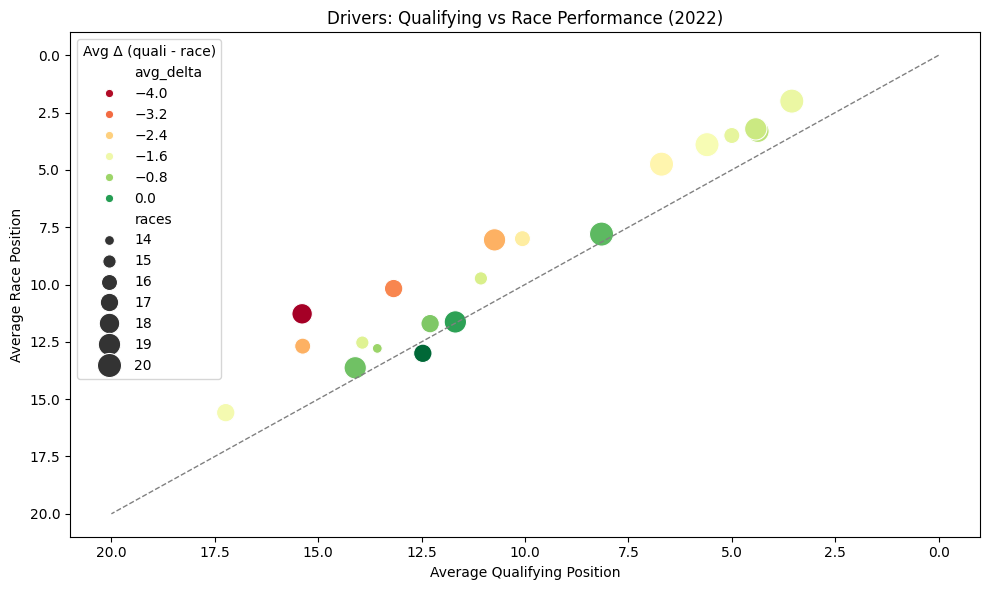

In [13]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=driver_perf, x="avg_quali", y="avg_race", hue="avg_delta", size="races", sizes=(50,300), palette="RdYlGn")
plt.plot([0,20],[0,20],"--",color="gray", linewidth=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Average Qualifying Position")
plt.ylabel("Average Race Position")
plt.title(f"Drivers: Qualifying vs Race Performance ({year})")
plt.legend(loc="best", title="Avg Δ (quali - race)")
plt.tight_layout()
plt.show()

####Top gainers / droppers (bar)

In [14]:
top_gainers = driver_perf.sort_values("avg_delta", ascending=False).head(10)
top_droppers = driver_perf.sort_values("avg_delta", ascending=True).head(10)

/var/folders/4w/0983xwzj4rjf72hxdhp98sxm0000gn/T/ipykernel_14730/2882670926.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gainers, x="avg_delta", y="driver_name", palette="viridis")


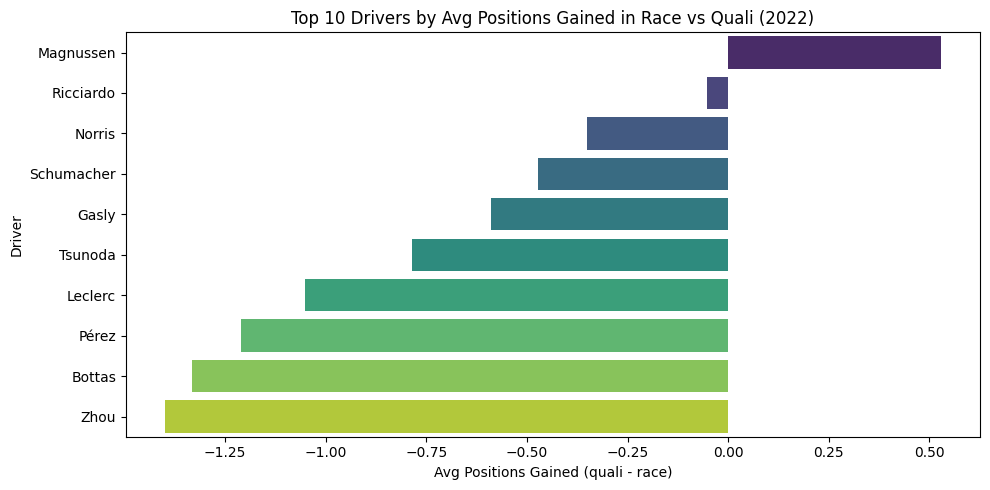

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_gainers, x="avg_delta", y="driver_name", palette="viridis")
plt.title(f"Top 10 Drivers by Avg Positions Gained in Race vs Quali ({year})")
plt.xlabel("Avg Positions Gained (quali - race)")
plt.ylabel("Driver")
plt.tight_layout()
plt.show()

/var/folders/4w/0983xwzj4rjf72hxdhp98sxm0000gn/T/ipykernel_14730/81681233.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_droppers, x="avg_delta", y="driver_name", palette="coolwarm")


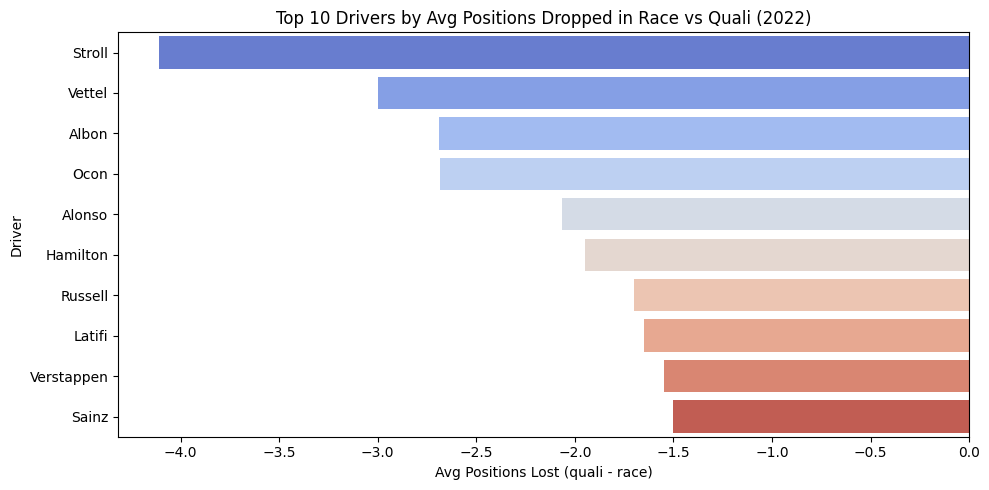

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_droppers, x="avg_delta", y="driver_name", palette="coolwarm")
plt.title(f"Top 10 Drivers by Avg Positions Dropped in Race vs Quali ({year})")
plt.xlabel("Avg Positions Lost (quali - race)")
plt.ylabel("Driver")
plt.tight_layout()
plt.show()

#### Distribution of race-to-race deltas per driver (consistency of gains/losses)

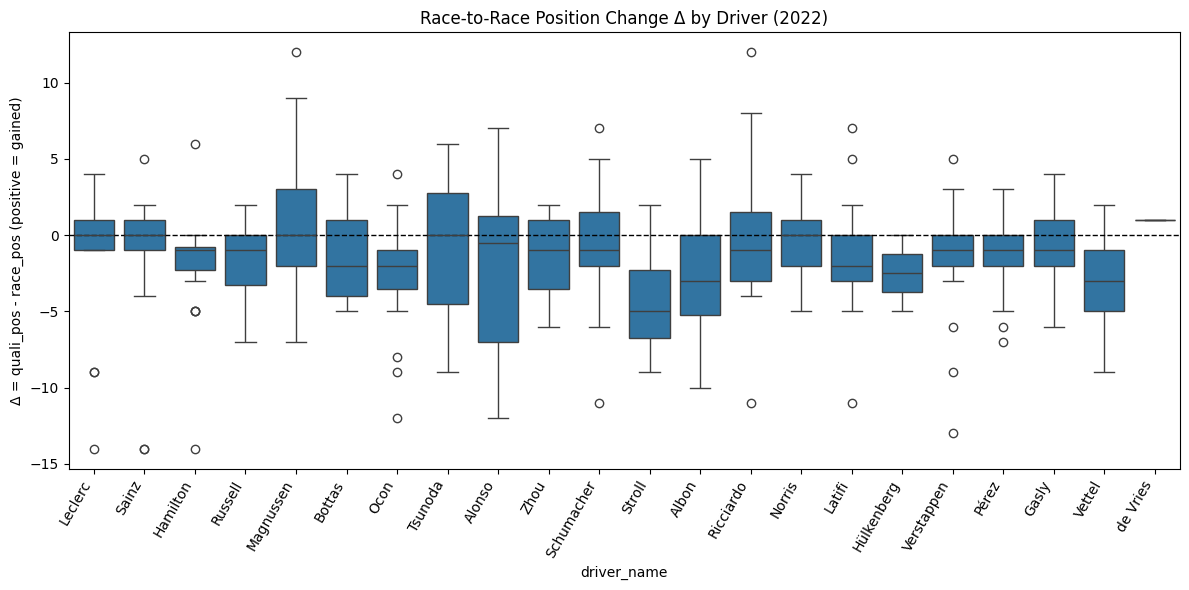

In [22]:
driver_deltas = (df_valid[["driver_name","round","delta"]]).copy()

plt.figure(figsize=(12,6))
sns.boxplot(data=driver_deltas, x="driver_name", y="delta")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title(f"Race-to-Race Position Change Δ by Driver ({year})")
plt.ylabel("Δ = quali_pos - race_pos (positive = gained)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

#### Heatmap per driver across rounds (finishing positions)

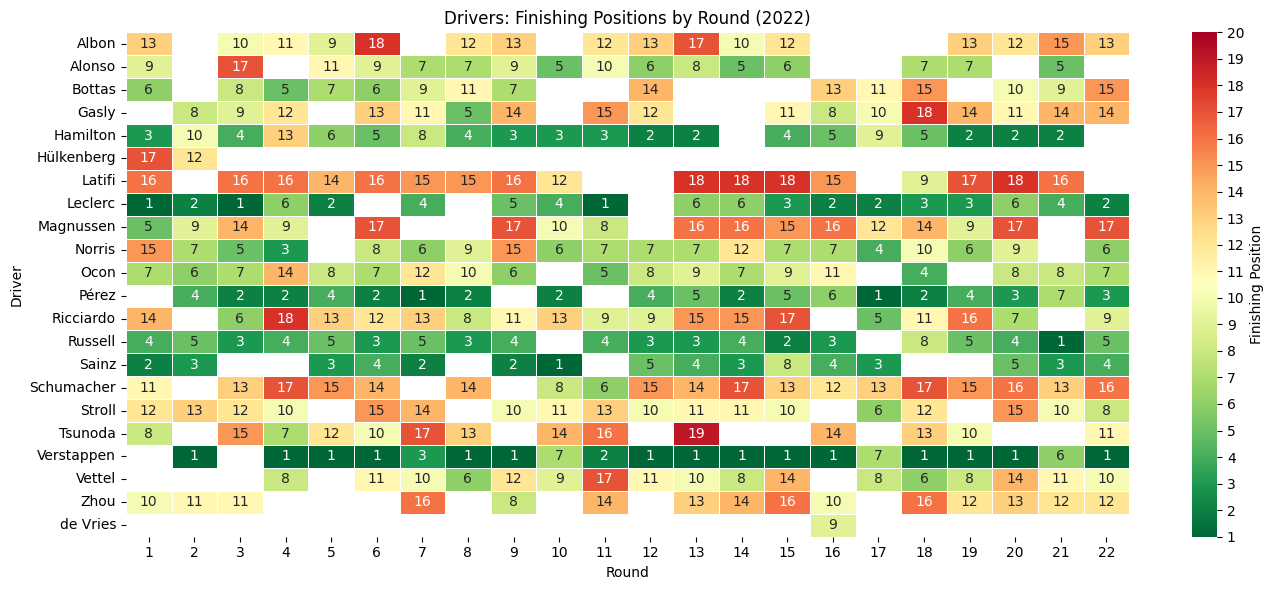

In [23]:
driver_round_pivot = (df_valid
                            .groupby(["driver_name", "round"], as_index=False)["race_pos"]
                            .min()
                            .pivot(index="driver_name", columns="round", values="race_pos")
                    )
plt.figure(figsize=(14,6))
ax = sns.heatmap(
                driver_round_pivot, 
                cmap="RdYlGn_r", 
                linewidths=0.5, 
                cbar_kws={'label':'Finishing Position'},
                annot=True,
                fmt="0.0f",
                vmin=1,
                vmax=20
)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(1,21,1))
cbar.set_ticklabels([str(i) for i in range(1,21)])
plt.title(f"Drivers: Finishing Positions by Round ({year})")
plt.ylabel("Driver")
plt.xlabel("Round")
plt.tight_layout()
plt.show()

###CONSTRUCTOR-LEVEL ANALYSES

#### Team average quali/race and delta

In [24]:
team_perf = (df_valid
             .groupby(["team_name"], as_index=False)
             .agg(
                 starts=("raceId","count"),
                 avg_quali=("quali_pos","mean"),
                 avg_race=("race_pos","mean"),
                 avg_delta=("delta","mean")
             )
            ).sort_values("avg_delta", ascending=False)

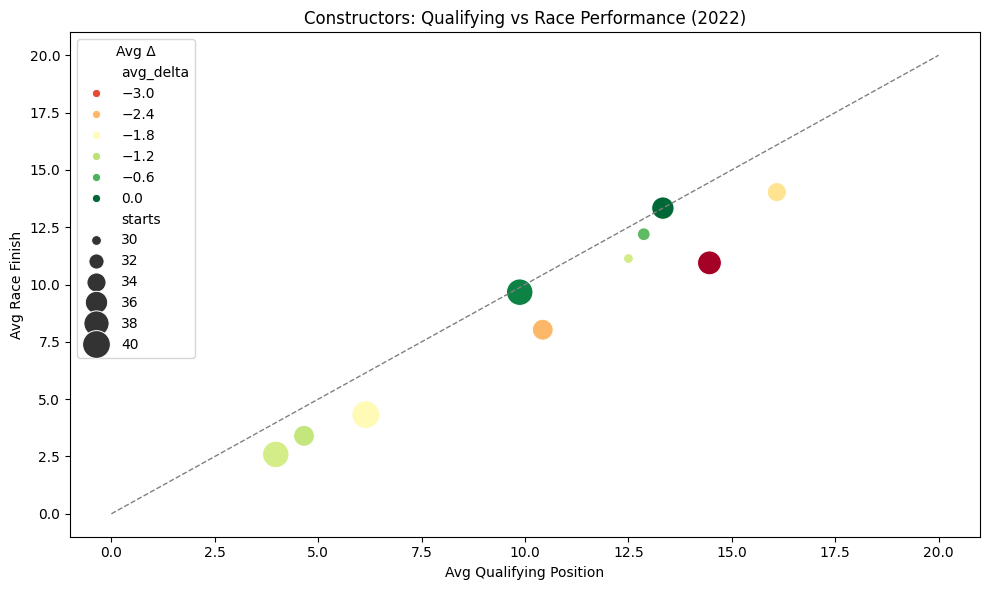

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=team_perf,
    x="avg_quali",
    y="avg_race",
    size="starts",
    hue="avg_delta",
    sizes=(50,400),
    palette="RdYlGn"
)
plt.plot([0,20], [0,20], "--", color="gray", linewidth=1)
plt.gca().invert_xaxis
plt.gca().invert_yaxis
plt.xlabel("Avg Qualifying Position")
plt.ylabel("Avg Race Finish")
plt.title(f"Constructors: Qualifying vs Race Performance ({year})")
plt.legend(loc="best", title="Avg Δ")
plt.tight_layout()
plt.show()

###CIRCUIT-LEVEL ANALYSES

#### Which circuits see the biggest quali→race changes on average?

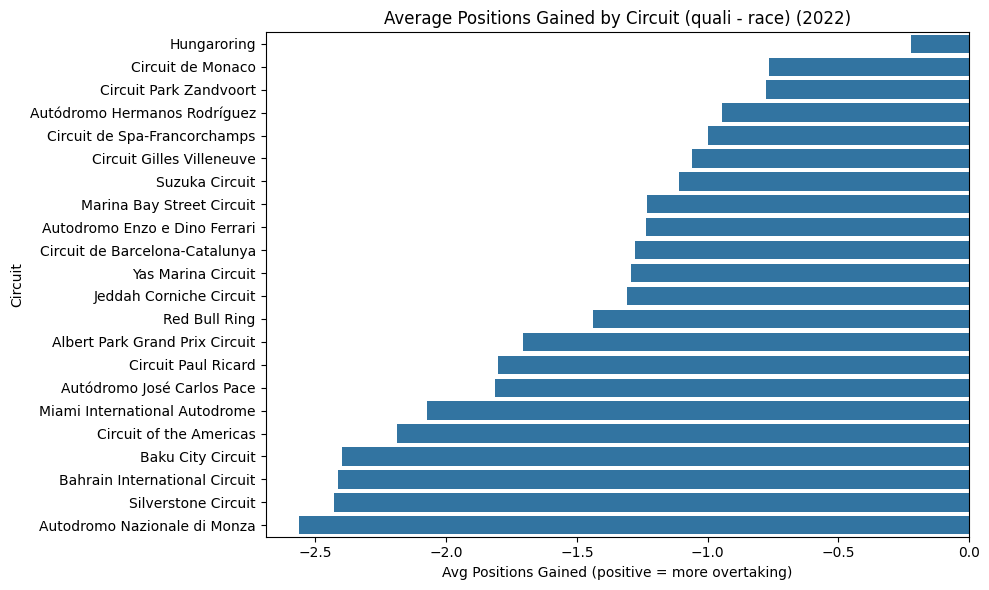

In [29]:
circuit_deltas = (df_valid
                        .groupby("circuit_name", as_index=False)
                        .agg(avg_delta=("delta", "mean"),
                        races=("raceId", "nunique"))
                        ).sort_values("avg_delta", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=circuit_deltas, x="avg_delta", y="circuit_name")
plt.title(f"Average Positions Gained by Circuit (quali - race) ({year})")
plt.xlabel("Avg Positions Gained (positive = more overtaking)")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()

####Who is the top gainer per circuit?

In [33]:
gains_by_driver_circuit = (df_valid
                            .groupby(["circuit_name","driver_name"], as_index=False)
                            .agg(gain=("delta","mean"), starts=("raceId","count"))
                          )

gains_by_driver_circuit = gains_by_driver_circuit[gains_by_driver_circuit["starts"] > 0]
idx = gains_by_driver_circuit.groupby("circuit_name")["gain"].idxmax()
best_gainers = gains_by_driver_circuit.loc[idx].sort_values("gain", ascending=False)

print("Top gainer per circuit (min 2 starts):")
display(best_gainers.head(15))

Top gainer per circuit (min 2 starts):


,circuit_name,driver_name,gain,starts
123,Circuit Gilles Villeneuve,Magnussen,12.0,1
27,Autodromo Enzo e Dino Ferrari,Ricciardo,12.0,1
172,Circuit de Barcelona-Catalunya,Magnussen,9.0,1
209,Circuit de Spa-Francorchamps,Ricciardo,8.0,1
1,Albert Park Grand Prix Circuit,Alonso,7.0,1
266,Marina Bay Street Circuit,Hamilton,6.0,1
242,Hungaroring,Ricciardo,6.0,1
197,Circuit de Monaco,Tsunoda,6.0,1
145,Circuit Park Zandvoort,Sainz,5.0,1
113,Baku City Circuit,Tsunoda,5.0,1


### Trend-lines

####Selected drivers: race finishing position across rounds

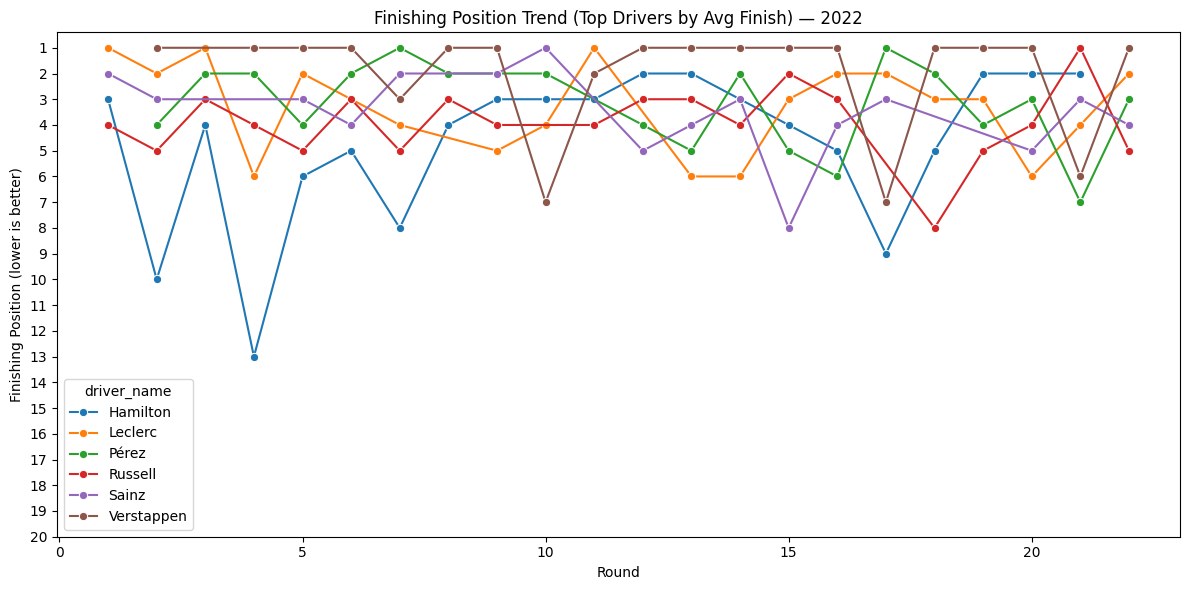

In [34]:
selected_drivers = driver_perf.sort_values("avg_race").head(6)["driver_name"].tolist()
trend = (df_valid[df_valid["driver_name"].isin(selected_drivers)]
         .groupby(["driver_name","round"], as_index=False)["race_pos"].min()
        )

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="round", y="race_pos", hue="driver_name", marker="o")
plt.gca().invert_yaxis()
plt.yticks(range(1,21))
plt.title(f"Finishing Position Trend (Top Drivers by Avg Finish) — {year}")
plt.xlabel("Round")
plt.ylabel("Finishing Position (lower is better)")
plt.tight_layout()
plt.show()
